# Лекция 7: Обработка естественного языка

## История развития

**Последовательность** — это дискретный набор элементов из конечного множества. Каждый элемент представляется вектором, между элементами задано отношение порядка.

### Цель
- Научиться обрабатывать последовательности переменной длины.

### Марковское свойство
- Определение: Если задана последовательность из $ t $ элементов $ x $, свойство наблюдается, если для предсказания следующего состояния достаточно конечного множества предыдущих элементов.
- Ограничение: На текстах Марковское свойство, как правило, не выполняется из-за сложной структуры языка.


### Рекуррентный блок
- **Пошаговая обработка:**
  $$
  h_{t+1} = f_0(h_t, x_t),
  $$
  где $ h_t $ — скрытое состояние на шаге $ t $, $ x_t $ — вход на шаге $ t $.

- **Применение:**
  - Используется для генерации последовательностей, предсказывая следующий токен, аналогично задаче классификации.
  - Конкатенируем $ h_t $ и $ x_t $, применяем линейный слой с нелинейной активацией для отображения в нужную размерность:
    $$
    h_{t+1} = \sigma(W[h_t, x_t] + b),
    $$
    где $ \sigma $ — функция активации (например, ReLU, sigmoid).

- **Передача скрытого состояния:**
  При необходимости скрытое состояние $ h_t $ передается в классификатор для предсказания следующего элемента (токена).

### Проблемы с градиентами
- **Взрывающийся градиент:**
  - Градиент увеличивается экспоненциально на длинных последовательностях.
  - Решение: нормировать градиент на фиксированное значение (gradient clipping).

- **Затухающий градиент:**
  - Градиент уменьшается с ростом длины последовательности, обратная связь отдаленных элементов ослабевает.
  - Решение: использовать функции активации с насыщением (sigmoid, tanh, т.е ограниченные сверху и снизу) и нормализацию (например, Layer Norm).

- **Функция активации ReLU:**
  - Может привести к неограниченному сверху значению градиентов.
  - Частичное решение: использовать нормализацию, например Layer Norm.


### Переход от RNN к LSTM
- **Разделение информации на два потока:**
  - Один поток используется для сложения и умножения без функций активации («долгосрочная память»).

- **Механизм забывания:**
  - Используется бинарная классификация для оценки важности каждой компоненты вектора.
  - Вычисленная вероятность важности умножается на текущий вектор (механизм забывания).

### LSTM (Long Short-Term Memory)
- **Компоненты:**
  1. **Входной элемент:** $ x_t $.
  2. **Скрытое состояние:** $ h_t $.
  3. **Ячейка памяти:** $ c_t $.

- **Основные этапы:**
  1. **Поток забывания:**
     $$
     f_t = \sigma(W_f[h_{t-1}, x_t] + b_f),
     $$
     где $ f_t $ определяет, какая часть старой информации будет забыта.

  2. **Поток обновления:**
     $$
     i_t = \sigma(W_i[h_{t-1}, x_t] + b_i),
     $$
     $$
     \tilde{c}_t = \tanh(W_c[h_{t-1}, x_t] + b_c),
     $$
     где $ i_t $ определяет важность нового кандидата $ \tilde{c}_t $.

  3. **Обновление ячейки памяти:**
     $$
     c_t = f_t \odot c_{t-1} + i_t \odot \tilde{c}_t.
     $$

  4. **Поток выхода:**
     $$
     o_t = \sigma(W_o[h_{t-1}, x_t] + b_o),
     $$
     $$
     h_t = o_t \odot \tanh(c_t).
     $$

- **Особенности:**
  - Ячейка памяти $ c_t $ обеспечивает долгосрочную память.
  - Гейты позволяют эффективно управлять потоками информации.


### GRU (Gated Recurrent Unit)
- **Отличия от LSTM:**
  - Упрощенная структура: нет отдельной ячейки памяти $ c_t $.
  - Объединение гейтов забывания и обновления в один гейт:
    $$
    z_t = \sigma(W_z[h_{t-1}, x_t] + b_z).
    $$
  - Обновление состояния:
    $$
    h_t = z_t \odot h_{t-1} + (1 - z_t) \odot \tilde{h}_t,
    $$
    где $ \tilde{h}_t $ — новый кандидат состояния.

- **Преимущества:**
  - Меньше параметров, чем в LSTM.
  - Более быстрые вычисления.


### Современные модификации: Mamba
- **Описание:**
  - Новая архитектура, оптимизирующая задачи генерации и классификации последовательностей.
  - Упрощенная структура гейтов для повышения вычислительной эффективности.

- **Особенности:**
  - Использование адаптивных механизмов нормализации.
  - Улучшенная способность моделировать долгосрочные зависимости.

## Векторизация

**Токен** — атомарный элемент последовательности. Токеном может быть:
- Слово,
- Символ,
- Морфема.

### Требования к векторным представлениям текста
Векторное представление текста должно:
1. Сохранять информацию о порядке слов.
2. Быть низкой размерности для уменьшения вычислительных затрат.
3. Быть не слишком разряженным.
4. Учитывать различные формы одного слова как идентичные (например, «кот» и «коты»).


<img src="https://www.researchgate.net/publication/343595281/figure/fig4/AS:963538206089244@1606736818940/Visualization-of-the-word-embedding-space.png" alt="Описание изображения" width="600">

[TensorFlow Projector](https://projector.tensorflow.org/)

### Основные методы представления текста

In [25]:
!pip install wordcloud nltk -q

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import nltk
from nltk.corpus import stopwords


def visualize_document_vectors(matrix, documents, title):
    """
    Снижает размерность матрицы векторов документов до 3D с помощью PCA
    и визуализирует результаты в виде 3D scatter plot.

    Аргументы:
        matrix : разреженная матрица размерности (n_documents, n_features)
        documents : список документов (строк) для аннотации точек
        title : заголовок графика
    """
    dense_matrix = matrix.toarray()
    pca = PCA(n_components=3)
    vectors_3d = pca.fit_transform(dense_matrix)

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(vectors_3d[:, 0], vectors_3d[:, 1], vectors_3d[:, 2], s=50, c='blue')

    # Добавляем аннотации: номер документа
    for idx, (x, y, z) in enumerate(vectors_3d):
        ax.text(x, y, z, f"Doc {idx+1}", fontsize=12)

    ax.set_title(title, fontsize=16)
    ax.set_xlabel("PCA компонент 1", fontsize=14)
    ax.set_ylabel("PCA компонент 2", fontsize=14)
    ax.set_zlabel("PCA компонент 3", fontsize=14)
    plt.tight_layout()
    plt.show()


documents = ["Москва – столица России, один из самых больших городов в мире.",
            "В Санкт-Петербурге много красивых зданий, и город знаменит своими музеями.",
            "Сочи известен своими курортами и горнолыжными курортами на Красной Поляне.",
            "Новосибирск – третий по численности населения город России.",
            "Екатеринбург является одним из самых важных промышленных центров страны."]

nltk.download('stopwords')
russian_stop_words = stopwords.words('russian')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alex\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Bag of Words (BoW)
- Простой метод, представляющий текст в виде вектора частотности слов.
- **Механизм:**
  1. Каждое слово из словаря получает свою позицию в векторе.
  2. Для каждого текста создается вектор, в котором подсчитывается количество упоминаний каждого слова.
- **Недостатки:**
  - Игнорирует порядок слов.
  - Разряженность векторов при большом словаре.
  - Не учитывает семантическую близость слов.

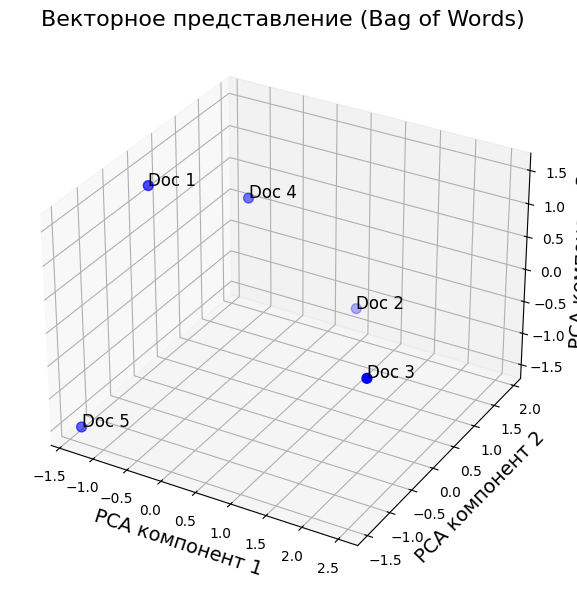

In [51]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(stop_words=russian_stop_words)
bow_matrix = bow_vectorizer.fit_transform(documents)
visualize_document_vectors(bow_matrix, documents, "Векторное представление (Bag of Words)")

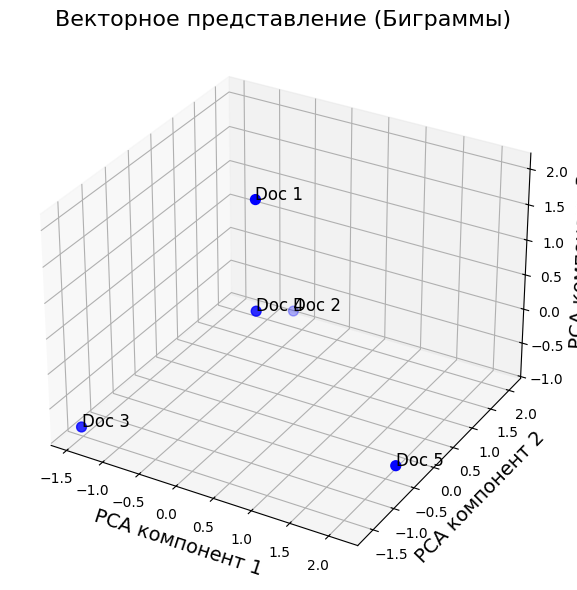

In [52]:
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words=russian_stop_words)
bigram_matrix = bigram_vectorizer.fit_transform(documents)
visualize_document_vectors(bigram_matrix, documents, "Векторное представление (Биграммы)")

#### WordNet
- Лексическая база данных, представляющая слова и их отношения в виде графа.
- **Особенности:**
  - Узлы графа — слова, а связи — их семантические отношения (синонимы, антонимы, гипонимы и т.д.).
  - Создан вручную, что делает процесс трудоемким.
- **Недостатки:** Ограниченная масштабируемость и адаптивность к новым данным.

<img src="https://devopedia.org/images/article/103/3039.1596456731.png" alt="Описание изображения" width="600">

#### TF-IDF (Term Frequency-Inverse Document Frequency)
- **Описание:** Метод для взвешивания значимости слов в документе.
- **Формула:**
  $$
  TF\text{-}IDF(w, d, D) = TF(w, d) \times IDF(w, D)
  $$
  где:
  - $ TF(w, d) = \frac{\text{Частота слова } w \text{ в документе } d}{\text{Общее количество слов в документе } d} $
  - $ IDF(w, D) = \log\frac{|D|}{1 + |\{d \in D : w \in d\}|} $

- **Особенности:**
  - Уменьшает значимость часто встречающихся слов (например, «и», «в»).
  - Учитывает редкие, информативные слова.

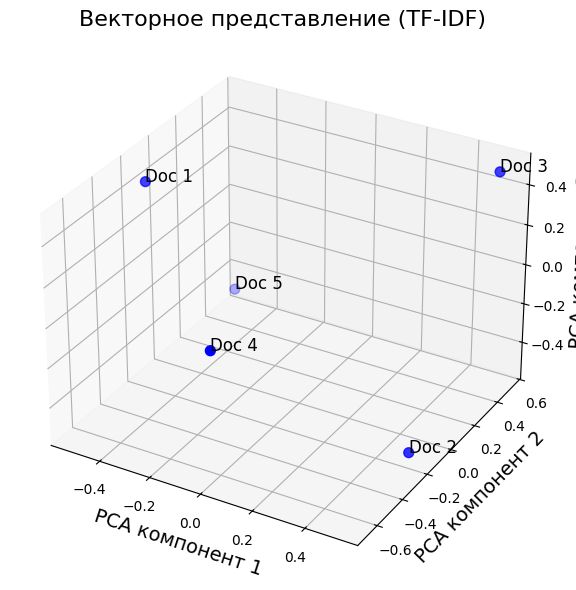

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words=russian_stop_words)
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)
visualize_document_vectors(tfidf_matrix, documents, "Векторное представление (TF-IDF)")

### Информативные векторные представления - эмбеддинги

#### Методы создания эмбеддингов

1. **Разложение матриц:**
   - Создается матрица совместной частоты слов.
   - С помощью методов, таких как сингулярное разложение (SVD), матрица преобразуется в более низкоранговые представления.

2. **Word2Vec:**
   - **Описание:** Метод построения векторных представлений слов с использованием нейронных сетей.
   - **Используемые термины:**
     - **N-граммы:** Последовательности из $ N $ токенов (слов или символов). Позволяет учитывать локальный контекст.
     - **Skip-граммы:** Нечетные последовательности токенов с пропуском центрального элемента.
   - **Принципы:**
     - Будем оценивать для каждого слова вероятность другого слова быть с ним в одном контексте.
     - Балансируем объекты так, чтобы часто используемые слова меньше использовались для обучения.
     - Для обучения используем negative sampling.

In [37]:
!pip install gensim -q

  You can safely remove it manually.
  You can safely remove it manually.


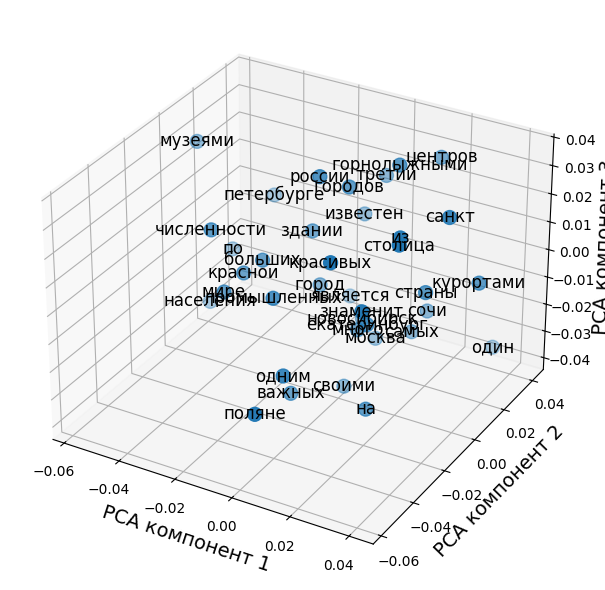

In [56]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

tokenized_docs = [simple_preprocess(doc, deacc=True) for doc in documents]
model = Word2Vec(sentences=tokenized_docs, vector_size=50, window=3, min_count=1, workers=1, seed=42)
word_vectors = model.wv

words = list(word_vectors.key_to_index.keys())

vectors = [word_vectors[word] for word in words]

pca = PCA(n_components=3)
vectors_3d = pca.fit_transform(vectors)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(vectors_3d[:, 0], vectors_3d[:, 1], vectors_3d[:, 2], s=100)

# Добавляем подписи для каждого слова
for i, word in enumerate(words):
    ax.text(vectors_3d[i, 0], vectors_3d[i, 1], vectors_3d[i, 2],
            word, fontsize=12, ha="center", va="center")

ax.set_xlabel("PCA компонент 1", fontsize=14)
ax.set_ylabel("PCA компонент 2", fontsize=14)
ax.set_zlabel("PCA компонент 3", fontsize=14)
plt.tight_layout()
plt.show()

### Контрастное обучение (Contrastive Learning)
- **Описание:** Метод, сближающий похожие (контекстно близкие) слова и отдаляющий непохожие.
- **Механизм Negative Sampling:**
  - Часто встречающиеся слова с большей вероятностью становятся «негативными примерами».
  - Пример: для пары слов (контекстное и целевое) подбираются случайные слова, которые не должны быть близкими по контексту.
- **Цель:** Преобразовать многоклассовую классификацию в двуклассовую задачу: «связанное слово или нет».

## Авторегрессионные модели

### Основы авторегрессионных моделей
- Последовательно обрабатывают элементы последовательности, формируя скрытый латентный вектор, кодирующий всю прочитанную последовательность.
- На каждом шаге:
  1. Формируется распределение вероятностей следующего токена.
  2. Выбирается токен с максимальной вероятностью (argmax).
  3. Этот токен подается снова на вход модели.

- **Правдоподобие сгенерированной последовательности:**
  $$
  P(x_1, x_2, \dots, x_T) = \prod_{t=1}^T P(x_t | x_1, x_2, \dots, x_{t-1}).
  $$

### Проблемы авторегрессии
- Предсказания основываются на собственных предыдущих предсказаниях.
- Ошибки критичны, так как накапливаются, приводя к деградации качества сгенерированной последовательности.

### Лучевой поиск (Beam Search)
- Метод для улучшения генерации последовательностей.
- На каждом этапе генерируется $ k $ (ширина луча) продолжений для каждого из текущих кандидатов.
- Продолжаются только $ k $ лучших последовательностей по правдоподобию.

- **Проблема коротких последовательностей:**
  - Короткие последовательности имеют более высокое правдоподобие.
  - Решение: нормировка оценки правдоподобия на длину последовательности.

<img src="https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/beam_search.png" alt="Описание изображения" width="600">


### Механизм внимания (Attention)
- Используется для обработки последовательностей разной длины.
- **Идея:** на каждом шаге вычисляется взвешенная сумма предыдущих состояний на основе их значимости для текущего состояния.

1. Для текущего состояния вычисляется скалярное произведение с каждым из предыдущих состояний.
2. Пропускается через softmax для получения весов.
3. Предыдущие состояния суммируются с учетом этих весов, так находится следующее состояние.

- **Применение:** позволяет учитывать значимость всех предыдущих элементов последовательности для текущего состояния.

### Self-Attention
- **Особенности:**
  - Квадратичная сложность относительно длины последовательности.
  - Оценивает отношение между элементами последовательности (например, словами в тексте).
  - Идейно изменяет скалярное произведение, поскольку слово один к слову два относится не также как второе к первому,нужно учитывать порядок слов.

- **Основные компоненты:**
  - **Queries ($ Q $):** отображение эмбеддинга в пространство "откуда" (из этого токена "смотрим").
  - **Keys ($ K $):** отображение эмбеддинга в пространство "куда" (на какой токен "смотрит").
  - **Values ($ V $):** смысловая информация токена (можно использовать сам эмбеддинг).

- **Алгоритм:**
  1. Умножаем эмбеддинги токенов на обучаемые матрицы $ W_Q $, $ W_K $, $ W_V $:
     $$
     Q = X W_Q, \quad K = X W_K, \quad V = X W_V.
     $$
  2. Вычисляем внимание между токенами $ i $ и $ j $:
     $$
     \text{Attention}(i, j) = \text{softmax}\left(\frac{Q_i K_j^T}{\sqrt{d}}\right),
     $$
     где $ d $ — размерность эмбеддинга (для уменьшения дисперсии).
  3. Умножаем значения внимания на $ V $ и складываем для получения нового представления токенов.

- **Многоголовое внимание (Multi-Head Attention):**
  - Независимо обучаются несколько вариантов матриц $ W_Q, W_K, W_V $.
  - Каждая головка создает новое представление токенов.
  - Итоговые представления объединяются и умножаются на матрицу $ W_O $:
    $$
    \text{Output} = \text{Concat}(\text{Head}_1, \dots, \text{Head}_h) W_O.
    $$

- **Преимущества:**
  - Учет различных типов взаимосвязей между токенами.
  - Распространяется на последовательности любого типа.

#### Подробные визуализации

<img src="https://jalammar.github.io/images/t/The_transformer_encoders_decoders.png" alt="Описание изображения" width="600">

<img src="https://jalammar.github.io/images/t/Transformer_decoder.png" alt="Описание изображения" width="600">

<img src="https://jalammar.github.io/images/t/embeddings.png" alt="Описание изображения" width="600">

<img src="https://jalammar.github.io/images/t/encoder_with_tensors.png" alt="Описание изображения" width="600">

<img src="https://jalammar.github.io/images/t/transformer_self_attention_vectors.png" alt="Описание изображения" width="600">

<img src="https://jalammar.github.io/images/t/self-attention-output.png" alt="Описание изображения" width="600">

<img src="https://jalammar.github.io/images/t/self-attention-matrix-calculation.png" alt="Описание изображения" width="600">

<img src="https://jalammar.github.io/images/t/self-attention-matrix-calculation-2.png" alt="Описание изображения" width="600">

<img src="https://jalammar.github.io/images/t/transformer_multi-headed_self-attention-recap.png" alt="Описание изображения" width="600">

<img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2019/11/image4.png" alt="Описание изображения" width="600">

[TensorFlow Tensor2Tensor](https://colab.research.google.com/github/tensorflow/tensor2tensor/blob/master/tensor2tensor/notebooks/hello_t2t.ipynb)

## LLMs

### Архитектура Encoder-Decoder

- Архитектура состоит из энкодера, который обрабатывает входные данные, и декодера, который генерирует выходные данные.
- Используется в задачах перевода, обобщения текста, генерации описаний и других.

### BERT
- **BERT (Bidirectional Encoder Representations from Transformers):** энкодерная архитектура, использующая Transformer.
- Направлен на глубокое понимание текста.

**Основные задачи при обучении:**
1. **Masked Language Modeling (MLM):**
   - Часть токенов маскируется специальным символом $[MASK]$, и модель обучается их предсказывать.
   - Формула вероятности предсказания:
     $$
     P(x_{\text{masked}} | x_{\text{context}}) = \prod_{i \in \text{masked}} P(x_i | x_{\text{context}}).
     $$
2. **Next Sentence Prediction (NSP):**
   - Задача бинарной классификации, определяющая, являются ли два предложения последовательными.

**Особенности:**
- Токены представлены как подстроки из часто встречающихся групп символов, для оптимизации (BPE, byte-pair encoding).
- Порядок слов кодируется с помощью позиционных эмбеддингов, например, можно раскладывать по гармоникам синусов и косинусов (один из вариантов):
  $$
  PE_{(pos, 2i)} = \sin(pos / 10000^{2i/d}), \quad PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i/d}),
  $$
  где $ pos $ — позиция слова, $ i $ — индекс вектора эмбеддинга, $ d $ — размерность эмбеддинга.

<img src="https://sushant-kumar.com/blog/bert-architecture.png" alt="Описание изображения" width="600">

In [2]:
!pip install transformers -q

In [ ]:
from transformers import pipeline, logging as hf_logging

hf_logging.set_verbosity_error()

fill_mask = pipeline("fill-mask", model="DeepPavlov/rubert-base-cased")
text = "Столица России - это [MASK]."
results = fill_mask(text)

print("Результаты заполнения маски:")
for res in results:
    token_str = res.get("token_str", "").strip()
    score = res.get("score", 0)
    print(f" - {token_str} (score: {score:.4f})")

### GPT
- **GPT (Generative Pre-trained Transformer):** декодерная архитектура.
- Основная задача: генерация текста, предсказание следующего токена.

**Режимы работы:**
1. **Zero-shot:** выполнение задач без дополнительного обучения.
2. **Few-shot:** выполнение задач после "обучения" в промпте на нескольких примерах.

**Особенности:**
- Подходит для генерации креативных текстов.
- Используется для диалоговых систем, креативного письма и других задач, требующих генерации.

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20240712150234/GPT-Arcihtecture.webp" alt="Описание изображения" width="600">

In [ ]:
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer

model_name = "sberbank-ai/rugpt3small_based_on_gpt2"
model = AutoModelForCausalLM.from_pretrained(model_name, pad_token_id=50256)
tokenizer = AutoTokenizer.from_pretrained(model_name)

generator = pipeline("text-generation", model=model, tokenizer=tokenizer)
prompt = "Дай определение предела по Коши"
results = generator(prompt, max_length=50, num_return_sequences=1)

print("Сгенерированный текст:")
for res in results:
    print(res["generated_text"])

### T5
- **T5 (Text-to-Text Transfer Transformer):** архитектура Encoder-Decoder.
- Универсальная модель, преобразующая любую задачу обработки текста в формат "входной текст → выходной текст".

**Особенности:**
- Использует Masked Language Modeling для нескольких токенов сразу.
- Применяется для перевода, обобщения, исправления грамматических ошибок и других задач.

<img src="https://www.researchgate.net/publication/371619795/figure/fig2/AS:11431281168463909@1686969039930/Architecture-of-the-T5-model.ppm" alt="Описание изображения" width="600">

In [ ]:
!pip install tiktoken -q

In [ ]:
from transformers import pipeline


summarizer = pipeline("summarization", model="sberbank-ai/ruT5-base")

text = (
    "Башня Лондона — исторический замок, расположенный на северном берегу реки Темзы в центре Лондона. "
    "Был построен в 1066 году в период нормандского завоевания Англии. "
    "Белая Башня, давшая название всему комплексу, была возведена Вильгельмом Завоевателем в 1078 году и стала символом власти и контроля. "
    "На протяжении веков замок служил и королевским дворцом, и тюрьмой. "
    "Сегодня он является одной из главных достопримечательностей Лондона."
)

t5_input = "сократи: " + text

summary = summarizer(t5_input, max_length=50, min_length=25, do_sample=False)

print("Результат суммаризации:")
print(summary[0]["summary_text"])